In [1]:
import numpy as np

from commons import *

In [2]:
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32

def get_gnn(n_nodes, gnn_hypers, opt_params, torch_device, torch_dtype):
    """
    Generate GNN instance with specified structure. Creates GNN, retrieves embedding layer,
    and instantiates ADAM optimizer given those.

    Input:
        n_nodes: Problem size (number of nodes in graph)
        gnn_hypers: Hyperparameters relevant to GNN structure
        opt_params: Hyperparameters relevant to ADAM optimizer
        torch_device: Whether to load pytorch variables onto CPU or GPU
        torch_dtype: Datatype to use for pytorch variables
    Output:
        net: GNN instance
        embed: Embedding layer to use as input to GNN
        optimizer: ADAM optimizer instance
    """
    dim_embedding = gnn_hypers['dim_embedding']
    hidden_dim = gnn_hypers['hidden_dim']
    dropout = gnn_hypers['dropout']
    number_classes = gnn_hypers['number_classes']

    # instantiate the GNN
    net = GCNSoftmax(dim_embedding, hidden_dim, number_classes, dropout, torch_device)
    net = net.type(torch_dtype).to(torch_device)
    embed = nn.Embedding(n_nodes, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)

    # set up Adam optimizer
    params = chain(net.parameters(), embed.parameters())
    optimizer = torch.optim.Adam(params, **opt_params)
    return net, embed, optimizer

def partition_weight(adj, s):
    """
    Calculates the sum of weights of edges that are in different partitions.

    :param adj: Adjacency matrix of the graph.
    :param s: List indicating the partition of each edge (0 or 1).
    :return: Sum of weights of edges in different partitions.
    """
    s = np.array(s)
    partition_matrix = np.not_equal.outer(s, s).astype(int)
    weight = (adj * partition_matrix).sum() / 2
    return weight

def calculateAllCut(q_torch, s):
    '''

    :param q_torch: The adjacent matrix of the graph
    :param s: The binary output from the neural network. s will be in form of [[prob1, prob2, ..., prob n], ...]
    :return: The calculated cut loss value
    '''
    if len(s) > 0:
        totalCuts = len(s[0])
        CutValue = 0
        for i in range(totalCuts):
            CutValue += partition_weight(q_torch, s[:,i])
        return CutValue/2
    return 0


def printCombo(orig):
    # Original dictionary
    input_dict = orig

    # Generate all permutations of the dictionary values
    value_permutations = list(permutations(input_dict.values()))

    # Create a list of dictionaries from the permutations
    permuted_dicts = [{key: value for key, value in zip(input_dict.keys(), perm)} for perm in value_permutations]

    return permuted_dicts

def GetOptimal(net, dgl_graph, inp, q_torch, terminal = None):

    probs = net(dgl_graph, inp, terminal)
    binary_partitions = (probs >= 0.5).float()

    for i in range(len(binary_partitions)-1):
        if torch.sum(binary_partitions[i]) != 1:
            binary_partitions[i] = torch.tensor([0,1,0])

    cut_value_item = calculateAllCut(q_torch, binary_partitions)

    return cut_value_item, binary_partitions

def GetOptimalNetValue(net, dgl_graph, inp, q_torch, terminal_dict):
    net.eval()
    best_loss = float('inf')
    best_binary = []
    # if (dgl_graph.number_of_nodes() < 30):
    #     inp = torch.ones((dgl_graph.number_of_nodes(), 30))

    # find all potential combination of terminal nodes with respective indices

    perm_items = printCombo(terminal_dict)
    for i in perm_items:
        probs = net(dgl_graph, inp, i)
        binary_partitions = (probs >= 0.5).float()
        # print([m for m in binary_partitions if sum(m)>1 or sum(m)==0])
        # print(binary_partitions, q_torch)
        cut_value_item = calculateAllCut(q_torch, binary_partitions)
        if cut_value_item < best_loss:
            best_loss = cut_value_item
            best_binary = binary_partitions
    return best_loss, best_binary

In [3]:

def hyperParameters(n = 100, d = 3, p = None, graph_type = 'reg', number_epochs = int(1e5),
                    learning_rate = 1e-4, PROB_THRESHOLD = 0.5, tol = 1e-4, patience = 100):
    dim_embedding = 80    # e.g. 10
    hidden_dim = int(dim_embedding/2)
    return n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim

In [4]:
def test1(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')
    # test_item_2 = {}
    # test_item_2[0]=test_item[1]
    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():
        # embed = nn.Embedding(graph.number_of_nodes(), dim_embedding)
        # embed = embed.type(TORCH_DTYPE).to(TORCH_DEVICE)
        # inputs = embed.weight
        #inputs = model.embed.weight
        # cut_val, partition = GetOptimal(model,dgl_graph, inputs, adjacency_matrix, {terminal[0]:0, terminal[1]:1, terminal[2]:2})
        # neural_cut.append(cut_val)
        print(inputs, inputs.size())
        logits = net(dgl_graph, inputs)
        binary_partitions = (logits >= 0.5).float()

        # for i in range(len(binary_partitions)-1):
        #     if torch.sum(binary_partitions[i]) != 1:
        #         binary_partitions[i] = torch.tensor([1,0,0])

        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        # cut_value, (part_1, part_2) = nx.minimum_cut(test_item_2[0][2], test_item_2[0][3][1], test_item_2[0][3][0], flow_func=shortest_augmenting_path)

        print("Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break


In [ ]:
test1('./final__80wayCut_LossOrig.pth')

In [ ]:
test1('./final__80wayCut_LossMinCut.pth')


In [ ]:
test1('./final__80wayCut_LossNew.pth')


In [ ]:
test1('./final__80wayCut_Losscomb.pth')


In [ ]:
test1('./final__80wayCut_Lossinter.pth')


In [ ]:
test1('./final__80wayCut_Lossinter_min_cut_loss.pth')





In [ ]:
test1('./final__80wayCut_Lossinter_min_cut_loss.pth')


In [ ]:
test1('./final__80wayCut_Lossinter_min_cut_loss_2.pth')

In [ ]:
test1('./final__80wayCut_Lossinter_min_cut_loss_3.pth')


In [ ]:
test1('./final__80wayCut_Lossinter_min_cut_loss_4.pth')


In [ ]:
test1('./final__80wayCut_Lossinter_min_cut_loss_5.pth')


In [ ]:
test1('./final__80wayCut_Lossinter_min_cut_loss_6.pth')


In [ ]:
test1('./final__80wayCut_Lossinter_min_cut_loss_7.pth')


In [ ]:
#with no terminal loss
test1('./final__80wayCut_Lossinter_min_cut_loss_9.pth')


In [ ]:
# with terminal loss
test1('./final__80wayCut_Lossinter_min_cut_loss_9.pth')


In [ ]:
# with terminal loss in NN
test1('./final__80wayCut_Lossinter_min_cut_loss_9.pth')


In [ ]:
# with terminal loss in NN
test1('./final__80wayCut_Lossinter_min_cut_loss_9.pth')


In [ ]:
# with terminal loss in NN
test1('./final__80wayCut_Lossinter_min_cut_loss_9.pth')


In [5]:
def test2(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')
    # test_item_2 = {}
    # test_item_2[0]=test_item[1]
    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():
        # embed = nn.Embedding(graph.number_of_nodes(), dim_embedding)
        # embed = embed.type(TORCH_DTYPE).to(TORCH_DEVICE)
        # inputs = embed.weight
        #inputs = model.embed.weight
        # cut_val, partition = GetOptimal(model,dgl_graph, inputs, adjacency_matrix, {terminal[0]:0, terminal[1]:1, terminal[2]:2})
        # neural_cut.append(cut_val)
        # print(inputs, inputs.size())
        logits = net(dgl_graph, adjacency_matrix)
        binary_partitions = (logits >= 0.5).float()

        # for i in range(len(binary_partitions)-1):
        #     if torch.sum(binary_partitions[i]) != 1:
        #         binary_partitions[i] = torch.tensor([1,0,0])

        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        # cut_value, (part_1, part_2) = nx.minimum_cut(test_item_2[0][2], test_item_2[0][3][1], test_item_2[0][3][0], flow_func=shortest_augmenting_path)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break


In [51]:
test2('./final__80wayCut_LossOrig_2.pth')


Neural 3-way min-cut value: tensor(672., dtype=torch.float64) 7.0 11.0 62.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([1., 0., 0.])2-tensor([0., 1., 0.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(277., dtype=torch.float64) 9.0 5.0 66.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 0., 1.])2-tensor([0., 1., 0.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(498., dtype=torch.float64) 5.0 6.0 69.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([1., 0., 0.])2-tensor([0., 1., 0.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(216., dtype=torch.float64) 9.0 6.0 65.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([0., 1., 0.])2-tensor([1., 0., 0.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(202., dtype=torch.float64) 9.0 15.0 56.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes

In [54]:
test2('./final__80wayCut_Lossinter_min_cut_loss_9_new.pth')


Neural 3-way min-cut value: tensor(321., dtype=torch.float64) 38.0 0.0 42.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([1., 0., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(37., dtype=torch.float64) 32.0 0.0 48.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([1., 0., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(102., dtype=torch.float64) 25.0 0.0 55.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 0., 1.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(135., dtype=torch.float64) 31.0 0.0 49.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 0., 1.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(384., dtype=torch.float64) 23.0 0.0 57.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([0., 0., 1.])2-tensor([0., 0., 1.])
Invalids Nod

In [56]:
test2('./final__80wayCut_Lossinter_min_cut_loss_10_new.pth')


Neural 3-way min-cut value: tensor(629., dtype=torch.float64) 51.0 21.0 8.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 1., 0.]) 1-tensor([1., 0., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(565., dtype=torch.float64) 69.0 5.0 6.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(734., dtype=torch.float64) 61.0 18.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 1., 0.]) 1-tensor([0., 0., 1.])2-tensor([1., 0., 0.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(525., dtype=torch.float64) 56.0 21.0 3.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(252., dtype=torch.float64) 49.0 16.0 15.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([1., 0., 0.])2-tensor([0., 1., 0.])
Invalids No

In [57]:
test2('./final__80wayCut_Lossinter_min_cut_loss_10_new.pth')


Neural 3-way min-cut value: tensor(653., dtype=torch.float64) 76.0 2.0 2.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([0., 1., 0.])2-tensor([1., 0., 0.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(10., dtype=torch.float64) 71.0 0.0 9.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([1., 0., 0.])2-tensor([1., 0., 0.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(338., dtype=torch.float64) 75.0 4.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(206., dtype=torch.float64) 71.0 7.0 2.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([1., 0., 0.])2-tensor([0., 1., 0.])
Invalids Nodes: 0
---------- 

Neural 3-way min-cut value: tensor(47., dtype=torch.float64) 72.0 0.0 8.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([1., 0., 0.])2-tensor([1., 0., 0.])
Invalids Nodes: 0


In [59]:
test2('./final__80wayCut_Lossinter_min_cut_loss_10_new.pth')


0 : number : Neural 3-way min-cut value: tensor(653., dtype=torch.float64) 76.0 2.0 2.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([0., 1., 0.])2-tensor([1., 0., 0.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(10., dtype=torch.float64) 71.0 0.0 9.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([1., 0., 0.])2-tensor([1., 0., 0.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(338., dtype=torch.float64) 75.0 4.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(206., dtype=torch.float64) 71.0 7.0 2.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([1., 0., 0.])2-tensor([0., 1., 0.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(47., dtype=torch.float64) 62.0 10.0 8.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.

In [62]:
test2('./final__80wayCut_LossOrig_2.pth')

0 : number : Neural 3-way min-cut value: tensor(338., dtype=torch.float64) 14.0 39.0 27.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 1., 0.]) 1-tensor([1., 0., 0.])2-tensor([1., 0., 0.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(84., dtype=torch.float64) 7.0 55.0 18.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 1., 0.]) 1-tensor([0., 0., 1.])2-tensor([1., 0., 0.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(478., dtype=torch.float64) 15.0 39.0 26.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([1., 0., 0.])2-tensor([0., 1., 0.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(604., dtype=torch.float64) 8.0 44.0 28.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(270., dtype=torch.float64) 13.0 44.0 23.0 Total Nodes:80.0
Terminalss: 0-tensor([0.

### Associated with Exp2
Removing terminal penalty, now using cloning


In [11]:
class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0])
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output



def testexp2(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():

        logits = net(dgl_graph, adjacency_matrix)
        logits = override_fixed_nodes(logits)
        binary_partitions = (logits >= 0.5).float()


        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break
testexp2('./final__80wayCut_LossExp2.pth')

0 : number : Neural 3-way min-cut value: tensor(130., dtype=torch.float64) 70.0 6.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(12., dtype=torch.float64) 70.0 6.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(50., dtype=torch.float64) 72.0 4.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(200., dtype=torch.float64) 72.0 3.0 5.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(70., dtype=torch.float64) 70.0 5.0 5.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.])

## Associated with Exp1 - loss
modified loss with terminal loss

In [13]:
class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0])
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output



def testexp1_loss(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():

        logits = net(dgl_graph, adjacency_matrix)
        # logits = override_fixed_nodes(logits)
        binary_partitions = (logits >= 0.5).float()


        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break
testexp1_loss('./final__80wayCut_LossExp1_loss.pth')

0 : number : Neural 3-way min-cut value: tensor(653., dtype=torch.float64) 56.0 6.0 18.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([0., 1., 0.])2-tensor([1., 0., 0.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(157., dtype=torch.float64) 69.0 1.0 10.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([1., 0., 0.])2-tensor([0., 1., 0.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(619., dtype=torch.float64) 60.0 12.0 8.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 1., 0.]) 1-tensor([1., 0., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(224., dtype=torch.float64) 53.0 15.0 12.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([1., 0., 0.])2-tensor([0., 1., 0.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(118., dtype=torch.float64) 55.0 16.0 9.0 Total Nodes:80.0
Terminalss: 0-tensor([0.,

## Associated with Exp2 - loss
modified loss with fixed terminal loss (using clone)

In [14]:
class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0])
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output



def testexp1_loss(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():

        logits = net(dgl_graph, adjacency_matrix)
        logits = override_fixed_nodes(logits)
        binary_partitions = (logits >= 0.5).float()


        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break
testexp1_loss('./final__80wayCut_LossExp2_loss.pth')

0 : number : Neural 3-way min-cut value: tensor(559., dtype=torch.float64) 78.0 1.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(262., dtype=torch.float64) 78.0 1.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(338., dtype=torch.float64) 78.0 1.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(498., dtype=torch.float64) 78.0 1.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(429., dtype=torch.float64) 78.0 1.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0

## Exp3
using binary loss

In [17]:
class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0])
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output



def testexp1_loss(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():

        logits = net(dgl_graph, adjacency_matrix)
        # logits = override_fixed_nodes(logits)
        binary_partitions = (logits >= 0.5).float()


        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break
testexp1_loss('./final__80wayCut_LossExp3_loss.pth')

0 : number : Neural 3-way min-cut value: tensor(441., dtype=torch.float64) 12.0 5.0 63.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 1., 0.]) 1-tensor([1., 0., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(134., dtype=torch.float64) 1.0 8.0 71.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 1., 0.]) 1-tensor([0., 0., 1.])2-tensor([1., 0., 0.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(375., dtype=torch.float64) 1.0 5.0 74.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([0., 1., 0.])2-tensor([1., 0., 0.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(218., dtype=torch.float64) 1.0 8.0 71.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([1., 0., 0.])2-tensor([0., 1., 0.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(299., dtype=torch.float64) 1.0 10.0 69.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 1.,

## Exp4
binary loss function with fixed penality

In [18]:
class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0])
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output



def testexp1_loss(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():

        logits = net(dgl_graph, adjacency_matrix)
        logits = override_fixed_nodes(logits)
        binary_partitions = (logits >= 0.5).float()


        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break
testexp1_loss('./final__80wayCut_LossExp4_loss.pth')

0 : number : Neural 3-way min-cut value: tensor(429., dtype=torch.float64) 75.0 1.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(150., dtype=torch.float64) 75.0 1.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(171., dtype=torch.float64) 75.0 1.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(345., dtype=torch.float64) 74.0 1.0 5.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(177., dtype=torch.float64) 75.0 1.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0

## Exp 5 - loss
Changing the loss function to intake binary input and find exact loss value +  loss function

In [19]:
class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0])
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output



def testexp1_loss(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():

        logits = net(dgl_graph, adjacency_matrix)
        logits = override_fixed_nodes(logits)
        binary_partitions = (logits >= 0.5).float()


        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break
testexp1_loss('./final__80wayCut_LossExp5_loss.pth')

0 : number : Neural 3-way min-cut value: tensor(127., dtype=torch.float64) 5.0 71.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(28., dtype=torch.float64) 8.0 68.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(60., dtype=torch.float64) 7.0 69.0 4.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(210., dtype=torch.float64) 5.0 72.0 3.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(133., dtype=torch.float64) 7.0 68.0 5.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]

## Exp 6 - loss
Changing the loss function to intake binary input and find exact loss value +  loss function + terminal loss

In [21]:
class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0])
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output



def testexp1_loss(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():

        logits = net(dgl_graph, adjacency_matrix)
        # logits = override_fixed_nodes(logits)
        binary_partitions = (logits >= 0.5).float()


        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break
testexp1_loss('./final__80wayCut_LossExp6_loss.pth')

0 : number : Neural 3-way min-cut value: tensor(472., dtype=torch.float64) 10.0 4.0 66.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 0., 1.])2-tensor([0., 1., 0.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(129., dtype=torch.float64) 1.0 8.0 71.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 1., 0.]) 1-tensor([0., 0., 1.])2-tensor([1., 0., 0.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(302., dtype=torch.float64) 1.0 12.0 67.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 0., 1.])2-tensor([0., 1., 0.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(430., dtype=torch.float64) 7.0 12.0 61.0 Total Nodes:80.0
Terminalss: 0-tensor([0., 0., 1.]) 1-tensor([0., 1., 0.])2-tensor([1., 0., 0.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(399., dtype=torch.float64) 1.0 16.0 63.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0

## Exp 7 - loss
Changing the loss function to intake binary input and find exact loss value +  loss function

In [ ]:
class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0])
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output



def testexp1_loss(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():

        logits = net(dgl_graph, adjacency_matrix)
        logits = override_fixed_nodes(logits)
        binary_partitions = (logits >= 0.5).float()


        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break
testexp1_loss('./final__80wayCut_LossExp7_loss.pth')

In [7]:
class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        # h = F.sigmoid(h)
        h = override_fixed_nodes(h)

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0])
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output


test2('./final__80wayCut_LossExp1.pth')

0 : number : Neural 3-way min-cut value: tensor(559., dtype=torch.float64) 78.0 1.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(262., dtype=torch.float64) 78.0 1.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(338., dtype=torch.float64) 78.0 1.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(498., dtype=torch.float64) 78.0 1.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(429., dtype=torch.float64) 78.0 1.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0

In [8]:
class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        # h = F.sigmoid(h)
        h = override_fixed_nodes(h)

        return h

def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0])
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0])
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0])
    return output


test2('./final__80wayCut_LossExp1.pth')

0 : number : Neural 3-way min-cut value: tensor(257., dtype=torch.float64) 5.0 74.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

1 : number : Neural 3-way min-cut value: tensor(144., dtype=torch.float64) 10.0 69.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

2 : number : Neural 3-way min-cut value: tensor(227., dtype=torch.float64) 7.0 72.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

3 : number : Neural 3-way min-cut value: tensor(343., dtype=torch.float64) 5.0 74.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 0.]) 1-tensor([0., 1., 0.])2-tensor([0., 0., 1.])
Invalids Nodes: 0
---------- 

4 : number : Neural 3-way min-cut value: tensor(367., dtype=torch.float64) 7.0 72.0 1.0 Total Nodes:80.0
Terminalss: 0-tensor([1., 0., 

In [191]:
# def test2():
#     n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)
#
#     # Establish pytorch GNN + optimizer
#     opt_params = {'lr': learning_rate}
#     gnn_hypers = {
#         'dim_embedding': dim_embedding,
#         'hidden_dim': hidden_dim,
#         'dropout': 0.0,
#         'number_classes': 2,
#         'prob_threshold': PROB_THRESHOLD,
#         'number_epochs': number_epochs,
#         'tolerance': tol,
#         'patience': patience,
#         'nodes':n
#     }
#     test_item = LoadData(fileName='./testData/dummy.pkl')
#     net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
#     # model = net
#     model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, '/Users/javaad/Documents/research/COP/models/2Way/small/exp_2way_epoch0_loss4895329096.pth')
#     model.eval()
#
#     neural_cut1 = []
#     for key, (dgl_graph, adjacency_matrix,graph) in test_item.items():
#         embed = nn.Embedding(graph.number_of_nodes(), dim_embedding)
#         embed = embed.type(TORCH_DTYPE).to(TORCH_DEVICE)
#         inputs = embed.weight
#         # inputs = torch.ones((dgl_graph.number_of_nodes(), dim_embedding))
#         neural_cut1.append(GetOptimalNetValue(model,dgl_graph, inputs, adjacency_matrix, {0:0, 5:1}))
#
#         print("Neural 2-way min-cut value: " + str(neural_cut1[-1].item()))
#     return neural_cut

In [117]:
# neural_cut = test2()

Neural 2-way min-cut value: 100.0
Neural 2-way min-cut value: 100.0


In [72]:
# heurestic_cut_k = LoadData('./testData/heurestic_cut_k.pkl')
# #

In [55]:
# from matplotlib.ticker import ScalarFormatter
# def barPlot_2(heurestic_cut, neural_cut):
#     # Example data
#     n_groups = len(heurestic_cut)
#     index = np.arange(n_groups)
#     bar_width = 0.35
#
#     # Create bars
#     plt.figure(figsize=(30, 6))
#     bar1 = plt.bar(index, heurestic_cut, bar_width, label='Heurestic')
#     bar2 = plt.bar(index + bar_width, neural_cut, bar_width, label='Neural Network')
#
#     # Add details
#     plt.xlabel('Graph Number')
#     plt.ylabel('Minimum Cut Value')
#     plt.title('Comparison of Minimum Cut Values by Algorithm')
#     # plt.xticks(index + bar_width / 2, range(1, n_groups + 1))
#     plt.legend()
#     # plt.tight_layout()
#     # plt.gca().yaxis.set(major_formatter=ScalarFormatter(), minor_formatter=ScalarFormatter());
#     plt.show()

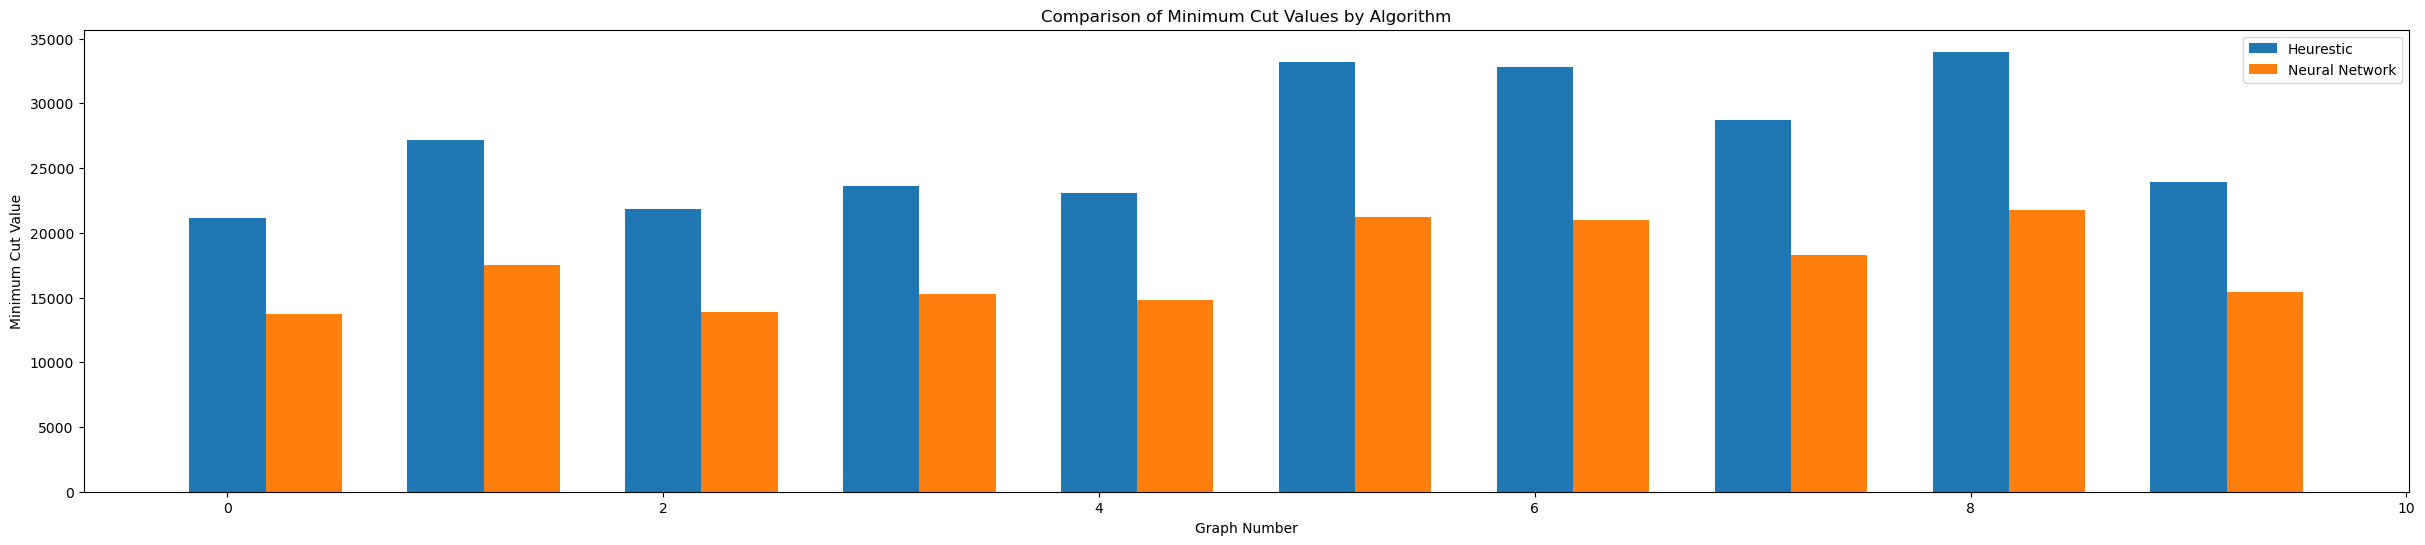

In [56]:
barPlot_2( heurestic_cut_k, neural_cut)